Optimal Total Distance: 174.0 

Salesman 1 Route: [(1, 5), (5, 1)]
Salesman 1 Specific Distance: 32
Salesman 2 Route: [(1, 2), (2, 3), (3, 4), (4, 1)]
Salesman 2 Specific Distance: 80
Salesman 3 Route: [(1, 6), (6, 1)]
Salesman 3 Specific Distance: 62


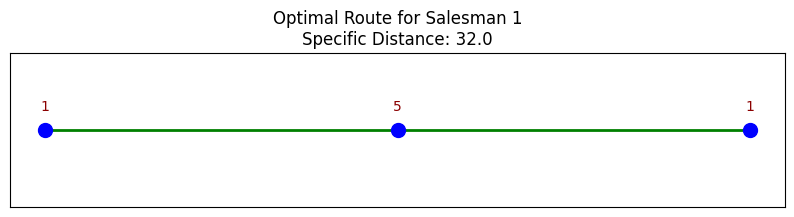

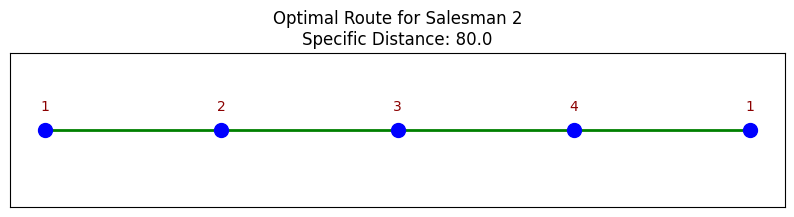

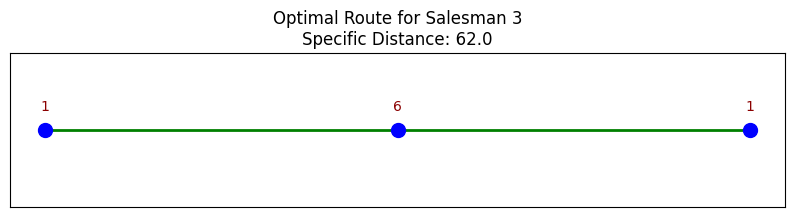

In [20]:
#! pip install pulp
from pulp import *
import matplotlib.pyplot as plt
import numpy as np

def solve_multi_tsp_with_pulp(distance_matrix, num_salesmen, depot=1, show_route=True, show_model=False):
    """
    Solve the Multi-Traveling Salesman Problem (Multi-TSP) using linear programming with PuLP.

    Parameters:
    - distance_matrix (2D list or numpy array): Matrix of distances between cities.
    - num_salesmen (int): Number of salesmen available.
    - depot (int): Starting city for all salesmen (default is 1, indexed from 1).
    - show_route (bool): If True, displays a plot of the optimal routes. Defaults to True.
    - show_model (bool): If True, prints the linear programming model used to solve the TSP. Defaults to False.
    """
    n = len(distance_matrix)
    tsp = LpProblem("Multi_Traveling_Salesman_Problem", LpMinimize)

    # Create binary decision variables x_ij_k for each pair of cities and each salesman
    x = LpVariable.dicts("x", ((i, j, k) for i in range(1, n+1) for j in range(1, n+1) for k in range(1, num_salesmen+1) if i != j), cat='Binary')

    # Create auxiliary variables u_i for subtour elimination (used for MTZ constraints)
    u = LpVariable.dicts("u", (i for i in range(1, n+1)), lowBound=0, upBound=n, cat='Continuous')

    # Objective function: Minimize the total travel distance
    tsp += lpSum(distance_matrix[i-1][j-1] * x[i, j, k] for i in range(1, n+1) for j in range(1, n+1) for k in range(1, num_salesmen+1) if i != j), "Total_Distance"

    # Constraints
    # 1. Each city (except the depot) must be visited exactly once by any salesman
    for j in range(1, n+1):
        if j != depot:
            tsp += lpSum(x[i, j, k] for i in range(1, n+1) for k in range(1, num_salesmen+1) if i != j) == 1, f"Visit_Constraint_{j}"

    # 2. Each salesman starts from the depot
    for k in range(1, num_salesmen+1):
        tsp += lpSum(x[depot, j, k] for j in range(1, n+1) if depot != j) == 1, f"Start_Constraint_Salesman_{k}"

    # 3. Each salesman ends at the depot
    for k in range(1, num_salesmen+1):
        tsp += lpSum(x[i, depot, k] for i in range(1, n+1) if depot != i) == 1, f"End_Constraint_Salesman_{k}"

    # 4. Flow conservation for each city (if a salesman enters a city, they must leave it)
    for k in range(1, num_salesmen+1):
        for j in range(1, n+1):
            if j != depot:
                tsp += lpSum(x[i, j, k] for i in range(1, n+1) if i != j) == lpSum(x[j, m, k] for m in range(1, n+1) if j != m), f"Flow_Constraint_{j}_Salesman_{k}"

    # 5. Subtour elimination constraints (MTZ constraints)
    for i in range(2, n+1):
        for j in range(2, n+1):
            if i != j:
                tsp += u[i] - u[j] + n * lpSum(x[i, j, k] for k in range(1, num_salesmen+1)) <= n - 1, f"Subtour_Elimination_{i}_{j}"

    # Solve the problem
    tsp.solve()

    # Retrieve and print the solution
    if tsp.status == LpStatusOptimal:
        routes = {k: [] for k in range(1, num_salesmen+1)}
        total_distances = {k: 0 for k in range(1, num_salesmen+1)}

        for k in range(1, num_salesmen+1):
            current_city = depot
            while True:
                for j in range(1, n+1):
                    if current_city != j and value(x[current_city, j, k]) == 1:
                        routes[k].append((current_city, j))
                        total_distances[k] += distance_matrix[current_city-1][j-1]  # Add distance for this segment
                        current_city = j
                        break
                if current_city == depot:
                    break

        print("Optimal Total Distance:", value(tsp.objective), "\n")
        for k, route in routes.items():
            print(f"Salesman {k} Route:", route)
            print(f"Salesman {k} Specific Distance: {total_distances[k]}")

        if show_model:
            print("\nModel Summary:\n")
            print(tsp)

        if show_route:
            for k, route in routes.items():
                plot_optimal_route_linear(route, total_distances[k], salesman_id=k)

    else:
        print("No optimal solution found.")


def plot_optimal_route_linear(optimal_tour, total_distance, salesman_id=1):
    """
    Plots the optimal route in a line for a single salesman's TSP.

    Parameters:
    - optimal_tour (list of tuples): Optimal path, e.g., [(1, 3), (3, 4), (4, 2), (2, 1)].
    - total_distance (float): Total distance of the optimal tour for this specific salesman.
    - salesman_id (int): Identifier for the salesman.
    """
    # Extract the order of cities from the optimal tour
    ordered_cities = [optimal_tour[0][0]]  # Start with the first city in the tour
    for _, next_city in optimal_tour:
        ordered_cities.append(next_city)

    # Generate positions along a line for each city in the order of the optimal tour
    x_coords = list(range(1, len(ordered_cities) + 1))
    y_coords = [1] * len(ordered_cities)  # Set a constant y-coordinate for all cities to place them in a line

    # Create a figure
    plt.figure(figsize=(10, 2))
    plt.title(f"Optimal Route for Salesman {salesman_id}\nSpecific Distance: {total_distance:.1f}")

    # Plot each city in the order of the optimal tour
    plt.scatter(x_coords, y_coords, color='blue', s=100, zorder=5)

    # Annotate each city with its index according to the ordered tour
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.text(x, y + 0.05, f'{ordered_cities[i]}', ha='center', color='darkred')

    # Plot the route by drawing lines in the order of the optimal tour
    for idx in range(len(ordered_cities) - 1):
        plt.plot([x_coords[idx], x_coords[idx + 1]], [1, 1], color='green', linestyle='-', linewidth=2)

    # Set plot limits and remove the y-axis for a clean linear view
    plt.ylim(0.8, 1.2)
    plt.xlabel("Cities")
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.show()


# Example usage
if __name__ == "__main__":
    distance_matrix = [
        [0, 29, 20, 21, 16, 31],
        [29, 0, 15, 29, 28, 40],
        [20, 15, 0, 15, 14, 25],
        [21, 29, 15, 0, 25, 35],
        [16, 28, 14, 25, 0, 30],
        [31, 40, 25, 35, 30, 0]
    ]
    num_salesmen = 3
    solve_multi_tsp_with_pulp(distance_matrix, num_salesmen, depot=1, show_route=True, show_model=False)

Optimal Total Distance: 174.0 

Salesman 1 Route: [(1, 5), (5, 1)]
Salesman 1 Specific Distance: 32
Salesman 2 Route: [(1, 2), (2, 3), (3, 4), (4, 1)]
Salesman 2 Specific Distance: 80
Salesman 3 Route: [(1, 6), (6, 1)]
Salesman 3 Specific Distance: 62


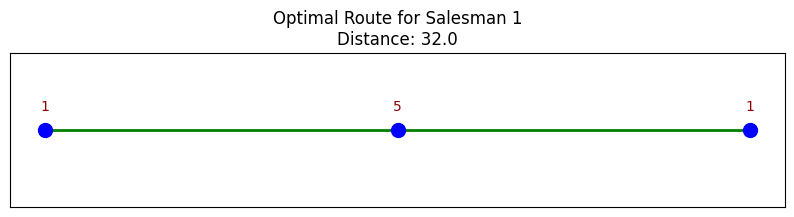

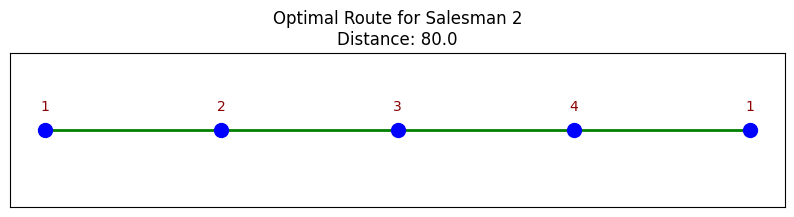

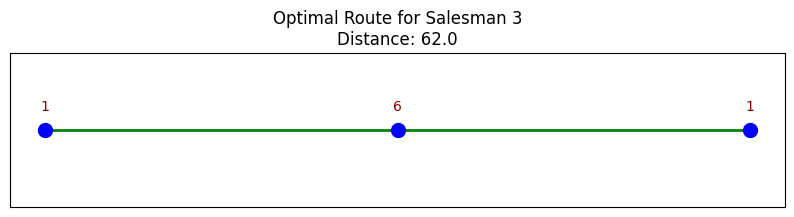

In [22]:
#! pip install pulp
from pulp import *
import matplotlib.pyplot as plt
import numpy as np

def solve_multi_tsp_with_pulp(distance_matrix, num_salesmen, depot=1, show_route=True, show_model=False):
    """
    Solve the Multi-Traveling Salesman Problem (Multi-TSP) using linear programming with PuLP.

    Parameters:
    - distance_matrix (2D list or numpy array): Matrix of distances between cities.
    - num_salesmen (int): Number of salesmen available.
    - depot (int): Starting city for all salesmen (default is 1, indexed from 1).
    - show_route (bool): If True, displays a plot of the optimal routes. Defaults to True.
    - show_model (bool): If True, prints the linear programming model used to solve the TSP. Defaults to False.
    """
    # Number of cities in the problem
    n = len(distance_matrix)

    # Define the linear programming problem
    # Objective is to minimize the total distance
    tsp = LpProblem("Multi_Traveling_Salesman_Problem", LpMinimize)

    # Define binary decision variables x[i, j, k]
    # x[i, j, k] = 1 if salesman k travels directly from city i to city j, 0 otherwise
    x = LpVariable.dicts("x",
                         ((i, j, k) for i in range(1, n+1)
                                     for j in range(1, n+1)
                                     for k in range(1, num_salesmen+1) if i != j),
                         cat='Binary')

    # Define auxiliary variables u[i] for subtour elimination
    # u[i] helps eliminate subtours by maintaining the sequence of visits
    u = LpVariable.dicts("u", (i for i in range(1, n+1)), lowBound=0, upBound=n, cat='Continuous')

    # Define the objective function: Minimize total travel distance
    tsp += lpSum(distance_matrix[i-1][j-1] * x[i, j, k]
                 for i in range(1, n+1)
                 for j in range(1, n+1)
                 for k in range(1, num_salesmen+1) if i != j), "Total_Distance"

    # Constraints
    # 1. Each city (except the depot) must be visited exactly once by one salesman
    for j in range(1, n+1):
        if j != depot:
            tsp += lpSum(x[i, j, k] for i in range(1, n+1)
                                       for k in range(1, num_salesmen+1) if i != j) == 1, f"Visit_Constraint_{j}"

    # 2. Each salesman must leave the depot exactly once
    for k in range(1, num_salesmen+1):
        tsp += lpSum(x[depot, j, k] for j in range(1, n+1) if depot != j) == 1, f"Start_Constraint_Salesman_{k}"

    # 3. Each salesman must return to the depot exactly once
    for k in range(1, num_salesmen+1):
        tsp += lpSum(x[i, depot, k] for i in range(1, n+1) if depot != i) == 1, f"End_Constraint_Salesman_{k}"

    # 4. Flow conservation: If a salesman enters a city, they must leave it
    for k in range(1, num_salesmen+1):
        for j in range(1, n+1):
            if j != depot:
                tsp += lpSum(x[i, j, k] for i in range(1, n+1) if i != j) == lpSum(x[j, m, k] for m in range(1, n+1) if j != m), f"Flow_Constraint_{j}_Salesman_{k}"

    # 5. Subtour elimination constraints (Miller-Tucker-Zemlin (MTZ) formulation)
    for i in range(2, n+1):
        for j in range(2, n+1):
            if i != j:
                tsp += u[i] - u[j] + n * lpSum(x[i, j, k] for k in range(1, num_salesmen+1)) <= n - 1, f"Subtour_Elimination_{i}_{j}"

    # Solve the problem
    tsp.solve()

    # Retrieve and print the solution if it's optimal
    if tsp.status == LpStatusOptimal:
        # Dictionary to store the route for each salesman
        routes = {k: [] for k in range(1, num_salesmen+1)}
        # Dictionary to store the total distance for each salesman
        total_distances = {k: 0 for k in range(1, num_salesmen+1)}

        # Extract the optimal routes for each salesman
        for k in range(1, num_salesmen+1):
            current_city = depot  # Start at the depot
            while True:
                for j in range(1, n+1):
                    if current_city != j and value(x[current_city, j, k]) == 1:
                        routes[k].append((current_city, j))  # Add the route segment
                        total_distances[k] += distance_matrix[current_city-1][j-1]  # Add the distance for this segment
                        current_city = j  # Move to the next city
                        break
                if current_city == depot:  # Stop when we return to the depot
                    break

        # Print the results
        print("Optimal Total Distance:", value(tsp.objective), "\n")
        for k, route in routes.items():
            print(f"Salesman {k} Route:", route)
            print(f"Salesman {k} Specific Distance: {total_distances[k]}")

        # Optionally print the full model (for debugging or analysis)
        if show_model:
            print("\nModel Summary:\n")
            print(tsp)

        # Optionally plot the routes for visualization
        if show_route:
            for k, route in routes.items():
                plot_optimal_route_linear(route, total_distances[k], salesman_id=k)

    else:
        # Print an error message if no optimal solution is found
        print("No optimal solution found.")


def plot_optimal_route_linear(optimal_tour, total_distance, salesman_id=1):
    """
    Plots the optimal route in a line for a single salesman's TSP.

    Parameters:
    - optimal_tour (list of tuples): Optimal path, e.g., [(1, 3), (3, 4), (4, 2), (2, 1)].
    - total_distance (float): Total distance of the optimal tour for this specific salesman.
    - salesman_id (int): Identifier for the salesman.
    """
    # Extract the order of cities from the optimal tour
    ordered_cities = [optimal_tour[0][0]]  # Start with the first city in the tour
    for _, next_city in optimal_tour:
        ordered_cities.append(next_city)

    # Generate positions along a line for each city in the order of the optimal tour
    x_coords = list(range(1, len(ordered_cities) + 1))
    y_coords = [1] * len(ordered_cities)  # Set a constant y-coordinate for all cities to place them in a line

    # Create a figure
    plt.figure(figsize=(10, 2))
    plt.title(f"Optimal Route for Salesman {salesman_id}\nDistance: {total_distance:.1f}")

    # Plot each city in the order of the optimal tour
    plt.scatter(x_coords, y_coords, color='blue', s=100, zorder=5)

    # Annotate each city with its index according to the ordered tour
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.text(x, y + 0.05, f'{ordered_cities[i]}', ha='center', color='darkred')

    # Plot the route by drawing lines in the order of the optimal tour
    for idx in range(len(ordered_cities) - 1):
        plt.plot([x_coords[idx], x_coords[idx + 1]], [1, 1], color='green', linestyle='-', linewidth=2)

    # Set plot limits and remove the y-axis for a clean linear view
    plt.ylim(0.8, 1.2)
    plt.xlabel("Cities")
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.show()


# Example usage
if __name__ == "__main__":
    distance_matrix = [
        [0, 29, 20, 21, 16, 31],
        [29, 0, 15, 29, 28, 40],
        [20, 15, 0, 15, 14, 25],
        [21, 29, 15, 0, 25, 35],
        [16, 28, 14, 25, 0, 30],
        [31, 40, 25, 35, 30, 0]
    ]
    num_salesmen = 3
    solve_multi_tsp_with_pulp(distance_matrix, num_salesmen, depot=1, show_route=True, show_model=False)